TBD

---

In [2]:
!pip install anytree

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 534 kB/s 


In [3]:
from anytree import NodeMixin, RenderTree
from anytree.exporter import DotExporter
from IPython.display import Image
from hashlib import sha256

class MerkleTree(NodeMixin):

  def __init__(self, name, parent=None, children=None):
    self.value = name
    if self.value is not None:
      self.name = MerkleTree._hash(self.value)
    else:
      self.name = None
    self.parent = parent
    if children:
      self.children = children
  
  def build(self, transactions):
      nodes = []
      self.transactions = []
      for tx in transactions:
        n = MerkleTree(tx)
        nodes.append(n)
    
      while len(nodes) > 1:
        new_level = []
        for i in range(0,len(nodes),2):
            node1 = nodes[i]
            if i+1 < len(nodes):
                node2 = nodes[i+1]
            else:
                new_level.append(nodes[i])
                break
            fake_value = node1.name + node2.name
            parent = MerkleTree(fake_value, children=[node1, node2])
            new_level.append(parent)
        nodes = new_level 
    
      return nodes[0]
  
  def _hash(input):
    return sha256(input.encode('utf-8')).hexdigest()

  def get_root_hash(self):
      return self.name

  def _nodenamefunc(node):
      if node.is_leaf:
        return "tx: " + node.value + "\n" + node.name 
      else:
        return node.name 

  def _nodeattrfunc(node):
      if node.is_leaf:
        return "shape=box" 
      else:
        return "shape=ellipse" 
  
  def get_transactions(self, hashes=True):
      if hashes:
        return ([node.name for node in self.leaves])
      else:
        return ([node.value for node in self.leaves])

  def print(self):
      for pre, _, node in RenderTree(self):
        if node.is_leaf:
          print(pre, node.name, "(tx:", node.value,")")
        else:
          print(pre, node.name)
  
  def show(self, img='mt.png'):
      de = DotExporter(mt, nodeattrfunc=MerkleTree._nodeattrfunc,
              nodenamefunc=MerkleTree._nodenamefunc).to_picture(img)
      return Image(img)

In [4]:
mt = MerkleTree(None)
mt = mt.build(['aa', 'bb', 'cc'])
mt.print()

 603228d3f0f74f6679ecc0e928a47ca7d486954d448bcfd7e156f3221095e971
├──  857b3347845d4297a11b88ed6e315e94773004f61ed1b027c583a5186e3579ca
│   ├──  961b6dd3ede3cb8ecbaacbd68de040cd78eb2ed5889130cceb4c49268ea4d506 (tx: aa )
│   └──  3b64db95cb55c763391c707108489ae18b4112d783300de38e033b4c98c3deaf (tx: bb )
└──  355b1bbfc96725cdce8f4a2708fda310a80e6d13315aec4e5eed2a75fe8032ce (tx: cc )


In [6]:
mt.get_transactions(hashes=True)

['961b6dd3ede3cb8ecbaacbd68de040cd78eb2ed5889130cceb4c49268ea4d506',
 '3b64db95cb55c763391c707108489ae18b4112d783300de38e033b4c98c3deaf',
 '355b1bbfc96725cdce8f4a2708fda310a80e6d13315aec4e5eed2a75fe8032ce']

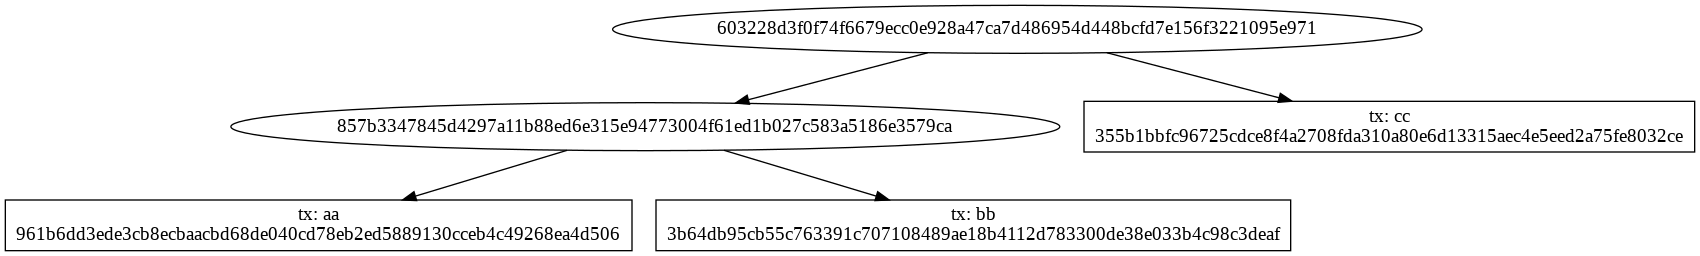

In [7]:
mt.show()

In [8]:
mt.get_root_hash()

'603228d3f0f74f6679ecc0e928a47ca7d486954d448bcfd7e156f3221095e971'

In [129]:
from random import randint
from hashlib import sha256
from datetime import datetime
from timeit import default_timer as timer
from tqdm.notebook import tqdm
import random
import json

class Blockchain:

  def __init__(self, name, difficulty=2, tx_per_block=2, initial_money=50):
    self.name = name
    self.difficulty = difficulty # default value
    self.transactions_per_block = tx_per_block # default value
    self.reward_money = initial_money # default value
    self.blocks = []
    self.hashed_blocks = dict()
    self.wallets = dict()
    self.pending_transactions = []
    self._add_genesis_block()

  def get_state(self, wallet, transactions=[]):    
    state = 0
    pos = None
    for i in range(0, len(self.blocks)):
      bk = self.blocks[i]
      for tx in bk['transactions']:
        if tx['source'] == wallet:
          state = tx['state_source']
          pos = i
        if tx['target'] == wallet:
          state = tx['state_target']
          pos= i
    
    for tx in transactions:
      #print("Additional transaction:", json.dumps(tx))
      if tx['source'] == wallet:
        state = tx['state_source']
        pos = -1
      if tx['target'] == wallet:
        state = tx['state_target']
        pos= -1

    return pos, state

  def _create_transaction(self, source, target, amount, state_source, state_target):
    formatted_tx = dict()
    formatted_tx['source'] = source
    formatted_tx['target'] = target
    formatted_tx['amount'] = amount

    if source  in self.wallets.keys():
      formatted_tx['state_source'] = state_source #self.wallets[source]
    else:
      formatted_tx['state_source'] = -1

    if target in self.wallets.keys():
      formatted_tx['state_target'] = state_target #self.wallets[target]
    else:
      formatted_tx['state_target'] = -1
      
    return formatted_tx
  
  # It transfers an amount of money from a source wallet to a target wallet
  # It the source wallet doesn't have enough money, the transfer is not executed
  def execute_money_transfer(self, source, target, amount, valid_transactions):
    # Both wallets must exist in the blockchain
    if (source != 'system') and (source not in self.wallets.keys()):
      return False, None
    if target not in self.wallets.keys():
      return False, None

    _, state_source_wallet = self.get_state(source, valid_transactions)
    _, state_target_wallet = self.get_state(target, valid_transactions)

    # The transfer operation
    if source == 'system':
      self.wallets[target] += amount
      state_target_wallet += amount
      tx = self._create_transaction(source, target, amount, state_source_wallet, state_target_wallet)
      #print(json.dumps(tx)
      return True, tx
    
    # TODO: This part should be done by "reconstructing" the states of the wallets, 
    # based on the history of transactions in the blocks
    # (instead of accessing directly to the wallets)
    if state_source_wallet >= amount: 
      self.wallets[source] -= amount
      self.wallets[target] += amount
      state_source_wallet -= amount
      state_target_wallet += amount
      tx = self._create_transaction(source, target, amount, state_source_wallet, state_target_wallet)
      #print(json.dumps(tx)
      return True, tx
    else:
      return False, None

  def execute_transaction(self, transaction, block_transactions=[]):
    list_args = transaction.split(' ')
    if 'sends' in list_args:
      # Parse the transaction and extract its arguments 
      source = list_args[0]
      target = list_args[4]
      amount = list_args[2][1:]
      # Execute the transaction
      ok, tx = self.execute_money_transfer(source, target, int(amount), valid_transactions=block_transactions)
      print("Executing transaction...", "wallet-"+source, "-->", "wallet-"+target, ":", "$",amount, "[", ok,"]")
      return ok, tx
    else:
      print("Unknown transaction:", transaction)
      return False, None

  def add_wallet(self, user):
    self.wallets[user] = 0

  def print_wallets(self, use_blocks=False):
    if use_blocks:
      print("blockchain:",self.name, "[wallets-from-blocks]")
      for k in self.wallets.keys():
        pos_block, state = self.get_state(k)
        print("\twallet-"+k,":", "$", state, "\t#"+str(pos_block))  
    else:
      print("blockchain:",self.name, "[wallets]")
      for k in self.wallets.keys():
        print("\twallet-"+k,":", "$",self.wallets[k])
  
  def print_transactions(self):
    print("blockchain:",self.name, "[pending-transactions]")
    for tx in self.pending_transactions:
      print("\t", tx)
  
  def _hash(input):
    return sha256(input.encode('utf-8')).hexdigest()
  
  def proof_of_work(self, nonce):
    print("Doing proof of work for:",nonce, "( difficulty:",self.difficulty,")")
    start = timer()
    header = '0'*self.difficulty
    #print(header)
    with tqdm(10) as pbar:
      while True:
        salt = random.random()
        guess_hash = Blockchain._hash(nonce + str(salt))
        #print(guess_hash)
        if guess_hash[:self.difficulty] == header:
          print("  ", guess_hash)
          end = timer()
          print("  ", "elapsed time (secs):", end - start) # Time in seconds
          return salt
        pbar.update(1)
  
  def _create_block(self, previous_hash, nonce, transactions, hash, merkle_tree):

      block = dict()
      block['previous_hash'] = previous_hash
      block['nonce'] = nonce
      block['transactions'] = transactions
      block['timestamp'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
      block['hash'] = hash
      block['merkle_tree'] = merkle_tree

      return block

  def _add_genesis_block(self):
    if len(self.blocks) == 0:
      print("Configuring genesis block ...")
      nonce = randint(0,1000)
      self.add_wallet('miner')
      
      self.proof_of_work(str(nonce))
      tx = "system sends $"+ str(self.reward_money) +" to miner" # reward
      valid_transactions = []
      for n in range (1, self.transactions_per_block+1):
        #print(tx)
        ok, formatted_tx = self.execute_transaction(tx, valid_transactions) 
        if ok:
          valid_transactions.append(formatted_tx)
      
      if len(valid_transactions) == 0:
        print("Warning: All transations failed, no block was created!")
        return

      json_transactions = [json.dumps(t) for t in valid_transactions]
      mt = MerkleTree(None)
      mt = mt.build(json_transactions)
      print("Merkle tree:")
      mt.print()
      
      previous_hash = Blockchain._hash(str(randint(0,1000)))
      input = str(nonce) + mt.get_root_hash() # " ".join(x for x in valid_transactions) 
      current_hash = Blockchain._hash(input)
      new_block = self._create_block(previous_hash, nonce, valid_transactions, current_hash, mt)

      self.blocks.append(new_block)
      return True
    
    else:
      print("Warning: Genesis block already exists!")
      return False
  
  def submit_transaction(self, tx, try_block=True):
    if len(self.blocks) > 0:
      self.pending_transactions.append(tx)
      print("Transaction stored and awaiting for block:",tx)

      if try_block:
        if len(self.pending_transactions) >= self.transactions_per_block:
          n_transactions = self.pending_transactions[0:self.transactions_per_block]
          self._add_block(n_transactions)

      return True
    else:
      print("Error: Genesis block is not configured!")
      return False
  
  def process_all_transactions(self):
    if len(self.blocks) > 0:
      self._add_block(self.pending_transactions)
      return True
    else:
      print("Error: Genesis block is not configured!")
      return False

  def _add_block(self, n_transactions):
    if len(self.blocks) > 0:
      print("Configuring new block ...")
      nonce = randint(0,1000)
      self.proof_of_work(str(nonce))

      valid_transactions = []
      for tx in n_transactions:
          self.pending_transactions.remove(tx)
          #print(tx)
          ok, formatted_tx = self.execute_transaction(tx, valid_transactions) # TODO: It might need to pass the valid transactions of this block as well
          if ok:
            valid_transactions.append(formatted_tx)
      
      tx = "system sends $"+ str(self.reward_money) +" to miner"
      ok, formatted_tx = self.execute_transaction(tx, valid_transactions)
      if ok:
        valid_transactions.append(formatted_tx)

      if len(valid_transactions) == 0:
        print("Warning: All transations failed, no block was created!")
        return

      json_transactions = [json.dumps(t) for t in valid_transactions]
      mt = MerkleTree(None)
      mt = mt.build(json_transactions)
      print("Merkle tree:")
      mt.print()
      
      previous_hash = self.blocks[-1]['hash']
      input = str(nonce) + mt.get_root_hash() # " ".join(x for x in valid_transactions) 
      current_hash = Blockchain._hash(input)
      new_block = self._create_block(previous_hash, nonce, valid_transactions, current_hash, mt)

      self.blocks.append(new_block)
    
    else:
      print("Error: Genesis block is not configured!")

  def print_blocks(self, show_mt=False):
    print("blockchain:",self.name, "[blocks]")
    n = 0
    for b in self.blocks:
      print(" #"+str(n)+":", b)
      n += 1
      if show_mt:
        b['merkle_tree'].print()
  
  def height(self):
    return len(self.blocks)

  def get_block(self, pos):
    return self.blocks[pos]


In [130]:
myblockchain = Blockchain('test', difficulty=3)

print()
myblockchain.print_wallets()
myblockchain.print_transactions()
myblockchain.print_blocks(show_mt=True)
myblockchain.print_wallets(use_blocks=True)

Configuring genesis block ...
Doing proof of work for: 872 ( difficulty: 3 )


0it [00:00, ?it/s]

   000f956f4742829945c8baecec35c4c709759fa52c48305435870a68f8ca6b7a
   elapsed time (secs): 0.06554064699957962
Executing transaction... wallet-system --> wallet-miner : $ 50 [ True ]
Executing transaction... wallet-system --> wallet-miner : $ 50 [ True ]
Merkle tree:
 ea2b91726756fcfa155760fd9fd92f15bfc42de50533a293ac0bd9469d191fbc
├──  fb5f6a3f58cbd6046948913062f3a9e3d9c499f4e60b537815acde64290f56d8 (tx: {"source": "system", "target": "miner", "amount": 50, "state_source": -1, "state_target": 50} )
└──  7c77fd0d0b6a0b63ca31631aa6fe97e7cb8ec20e67c8056fbac3fef1d3177c2c (tx: {"source": "system", "target": "miner", "amount": 50, "state_source": -1, "state_target": 100} )

blockchain: test [wallets]
	wallet-miner : $ 100
blockchain: test [pending-transactions]
blockchain: test [blocks]
 #0: {'previous_hash': '0d6f9709edaeba4bebf576d6b886b8c7083374f521f5256bf571add42fc7465c', 'nonce': 872, 'transactions': [{'source': 'system', 'target': 'miner', 'amount': 50, 'state_source': -1, 'state_tar

In [131]:
myblockchain.add_wallet('bob')
myblockchain.add_wallet('alice')
myblockchain.add_wallet('john')
myblockchain.print_wallets()

# Predefined transactions
tx0 = 'miner sends $70 to bob'
tx1 = 'bob sends $30 to alice'
tx2 = 'bob receives $1000 to alice'
tx3 = 'bob sends $1000 to alice'
tx4 = 'bob sends $10 to john'

_ = myblockchain.submit_transaction(tx0)

blockchain: test [wallets]
	wallet-miner : $ 100
	wallet-bob : $ 0
	wallet-alice : $ 0
	wallet-john : $ 0
Transaction stored and awaiting for block: miner sends $70 to bob


In [132]:
myblockchain.submit_transaction(tx1)
myblockchain.submit_transaction(tx2)
myblockchain.submit_transaction(tx3)
myblockchain.submit_transaction(tx4)
_ = myblockchain.process_all_transactions()

Transaction stored and awaiting for block: bob sends $30 to alice
Configuring new block ...
Doing proof of work for: 805 ( difficulty: 3 )


0it [00:00, ?it/s]

   000464559f4e61feb51cd52246cfe7816569d4e24b9112f3420fd7f85569bfd7
   elapsed time (secs): 0.09940323100090609
Executing transaction... wallet-miner --> wallet-bob : $ 70 [ True ]
Executing transaction... wallet-bob --> wallet-alice : $ 30 [ True ]
Executing transaction... wallet-system --> wallet-miner : $ 50 [ True ]
Merkle tree:
 16cbaa924ea3e673c893a60e72f3d82efa4602a2d336a180ca7956bf0dd49765
├──  2c568b64f05d98d34f65928a6b2739a15c600ff6d05c4d8566277fe40fce48c7
│   ├──  ae9b9c2dbb688bfb36a474bebeb520d3bb0c383e3402a20e7becb13bfffdf81e (tx: {"source": "miner", "target": "bob", "amount": 70, "state_source": 30, "state_target": 70} )
│   └──  c490b3244f527edbaf57f7e733bceb5d821800041da8285a4e021868dd6f7c2a (tx: {"source": "bob", "target": "alice", "amount": 30, "state_source": 40, "state_target": 30} )
└──  dd56634853cf51a159a3f3f8f0fbb8bfc6ba0985067bcb06a28e4d0494aa2c2a (tx: {"source": "system", "target": "miner", "amount": 50, "state_source": -1, "state_target": 80} )
Transaction st

0it [00:00, ?it/s]

   000e78cdf9415a2225861acf7dbc2648962e9aaaa8623fb0afed123c6179cbee
   elapsed time (secs): 0.09513418400092633
Unknown transaction: bob receives $1000 to alice
Executing transaction... wallet-bob --> wallet-alice : $ 1000 [ False ]
Executing transaction... wallet-system --> wallet-miner : $ 50 [ True ]
Merkle tree:
 90bc2cee428cb86a0a8a81ca223431e5b21f001c5e8ca4d5730e797daec5bf86 (tx: {"source": "system", "target": "miner", "amount": 50, "state_source": -1, "state_target": 130} )
Transaction stored and awaiting for block: bob sends $10 to john
Configuring new block ...
Doing proof of work for: 414 ( difficulty: 3 )


0it [00:00, ?it/s]

   000a12faae6fada06df47c66b822499a7c2ccfbbddbb30893c63cb0f9f86d8b2
   elapsed time (secs): 0.0777993179999612
Executing transaction... wallet-bob --> wallet-john : $ 10 [ True ]
Executing transaction... wallet-system --> wallet-miner : $ 50 [ True ]
Merkle tree:
 1e41cf61c9421921c9cba489a2f5ca2e358c1ac9caca4b82fe60f11defb94fcf
├──  b5b5b263d5509d585c151566636a89d038d23bbae156c264e0dcef95e4075165 (tx: {"source": "bob", "target": "john", "amount": 10, "state_source": 30, "state_target": 10} )
└──  ead1e7d0f0377b581ff60ef55415c37391a5c1024bb8befd74937283834c723d (tx: {"source": "system", "target": "miner", "amount": 50, "state_source": -1, "state_target": 180} )


In [133]:
myblockchain.print_wallets()
myblockchain.print_transactions()
myblockchain.print_blocks(show_mt=False)
myblockchain.print_wallets(use_blocks=True)

blockchain: test [wallets]
	wallet-miner : $ 180
	wallet-bob : $ 30
	wallet-alice : $ 30
	wallet-john : $ 10
blockchain: test [pending-transactions]
blockchain: test [blocks]
 #0: {'previous_hash': '0d6f9709edaeba4bebf576d6b886b8c7083374f521f5256bf571add42fc7465c', 'nonce': 872, 'transactions': [{'source': 'system', 'target': 'miner', 'amount': 50, 'state_source': -1, 'state_target': 50}, {'source': 'system', 'target': 'miner', 'amount': 50, 'state_source': -1, 'state_target': 100}], 'timestamp': '2022-06-19 02:05:05', 'hash': '70eb9b6b9a3149b88a1ce5707ab36f2f51d5d8a247a1d0d550ef3369b57568ff', 'merkle_tree': <__main__.MerkleTree object at 0x7f6535cd1990>}
 #1: {'previous_hash': '70eb9b6b9a3149b88a1ce5707ab36f2f51d5d8a247a1d0d550ef3369b57568ff', 'nonce': 805, 'transactions': [{'source': 'miner', 'target': 'bob', 'amount': 70, 'state_source': 30, 'state_target': 70}, {'source': 'bob', 'target': 'alice', 'amount': 30, 'state_source': 40, 'state_target': 30}, {'source': 'system', 'target':

In [136]:
print("Height:", myblockchain.height())
block2 = myblockchain.get_block(2)
block2

Height: 4


{'hash': 'ca980e739a3c2227564f7e7c177d9b8debeb2d810690d750852855c74e4914cf',
 'merkle_tree': <__main__.MerkleTree at 0x7f6535d730d0>,
 'nonce': 707,
 'previous_hash': '2c54981787753a98061c0052cc1899caa8cb7dbbad412c4ee0999ee69834c060',
 'timestamp': '2022-06-19 02:05:11',
 'transactions': [{'amount': 50,
   'source': 'system',
   'state_source': -1,
   'state_target': 130,
   'target': 'miner'}]}

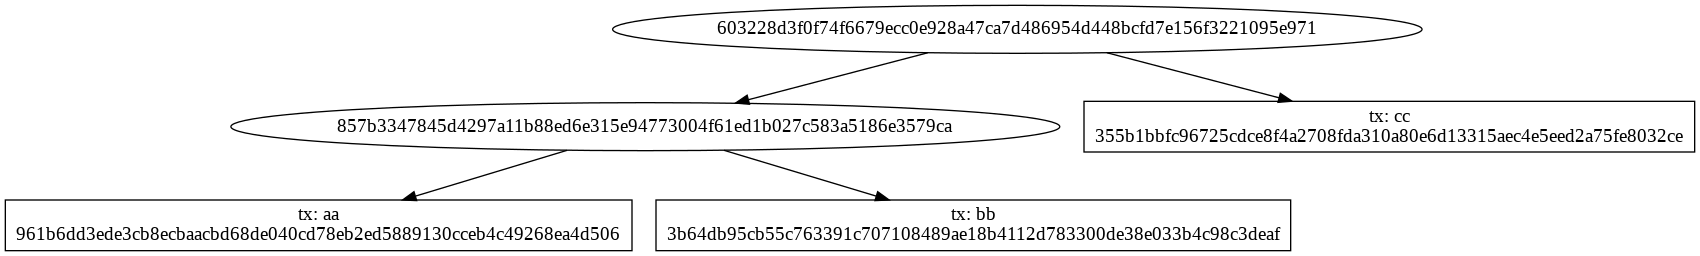

In [138]:
block2['merkle_tree'].show()

---